In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
import zipfile

with zipfile.ZipFile('olist_data.zip', 'r') as zip_ref:
    zip_ref.extractall('olist_data')

In [3]:
import pandas as pd

orders = pd.read_csv('olist_data/olist_orders_dataset.csv')
customers = pd.read_csv('olist_data/olist_customers_dataset.csv')
items = pd.read_csv('olist_data/olist_order_items_dataset.csv')

In [5]:
print(orders.head())
print(customers.head())
print(items.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

In [6]:
#filter out canceled orders
orders = orders[orders['order_status'] != 'canceled']

In [7]:
#Merge orders with customers on customer id feature
orders_customers = pd.merge(orders, customers, on='customer_id', how='left')

In [8]:
#Merge orders_customers with items on order id feature
full_olist = pd.merge(orders_customers, items, on='order_id', how='left')

In [9]:
#Convert date columns to datetime
full_olist['order_purchase_timestamp'] = pd.to_datetime(full_olist['order_purchase_timestamp'])

In [10]:
#Remove missing prices
full_olist = full_olist.dropna(subset=['price'])

In [11]:
full_olist.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

In [12]:
#RFM Grouping
# Latest date for recency
today = full_olist['order_purchase_timestamp'].max()

rfm = full_olist.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (today - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

In [19]:
rfm['monetary'] = rfm['monetary'].astype(int)

In [20]:
rfm.head()

,customer_id,recency,frequency,monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18,0
2,0000f46a3911fa3c0805444483337064,541,1,69,1
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25,1
4,0004aac84e0df4da2b147fca70cf8255,292,1,180,1


In [21]:
#Normalize the RFM features for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select only the numeric columns
rfm_features = rfm[['recency', 'frequency', 'monetary']]

#Scale.....
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

In [22]:
# Define the model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model and predict clusters
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

In [23]:
rfm.head()

,customer_id,recency,frequency,monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18,0
2,0000f46a3911fa3c0805444483337064,541,1,69,1
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25,1
4,0004aac84e0df4da2b147fca70cf8255,292,1,180,1


In [24]:
#Analyze Customer Segments
rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'})

,recency,frequency,monetary,num_customers
cluster,,,,
0,132.433840,1.000000,111.721954,51549
1,392.594482,1.000000,111.772435,38055
2,225.642433,2.114296,242.651171,2861
3,245.094295,1.011094,1082.618859,2524


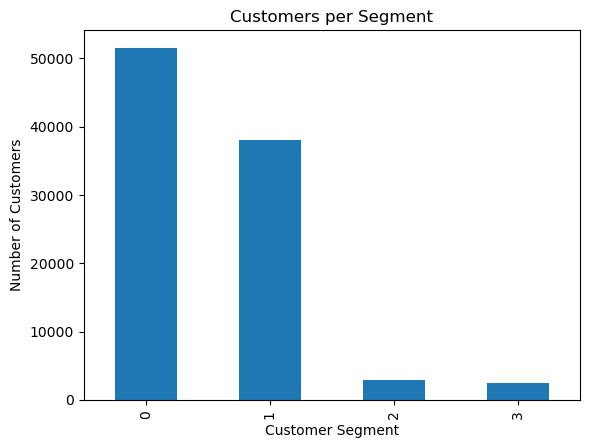

In [25]:
rfm['cluster'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customers per Segment')
plt.show()

In [26]:
import joblib

# Save model and scaler
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')    

['scaler.pkl']